In [1]:
import os
import sys

In [2]:
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

In [3]:
sys.path.append("../deep-learning-dna")
sys.path.append("../settransformer")

In [4]:
import tensorflow as tf
import tensorflow.keras as keras
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display
import math
import string

import settransformer as stf
from common.models import dnabert
from common import dna
from lmdbm import Lmdb
from common.data import DnaSequenceGenerator, DnaLabelType, DnaSampleGenerator, find_dbs
import wandb

import tf_utils as tfu

In [9]:
strategy = tfu.devices.select_gpu(0, use_dynamic_memory=True)

---
# Load Data

In [10]:
#Import pretrained model
api = wandb.Api()
model_path = api.artifact("sirdavidludwig/deep-learning-dna/dnabert-pretrain-ablation-dim:8dim").download()
pretrained_model = dnabert.DnaBertModel.load(model_path)
pretrained_model

In [11]:
#Load datafiles
dataset_path = api.artifact("sirdavidludwig/nachusa-dna/dnasamples:v1").download('/data/dna_samples:v1')
samples = find_dbs(dataset_path + '/train')
samples[13]

wandb: Downloading large artifact dnasamples:v1, 4086.55MB. 1260 files... Done. 0:0:0.3


'/data/dna_samples:v1/train/WS-CCW-Jul2015_S82_L001_R1_001.db'

---
# Create Dataset

In [12]:
#Generate batches
subsample_length = 500
sequence_length = 150
kmer = 3
batch_size = 20
batches_per_epoch = 20
augument = True
labels = DnaLabelType.SampleIds
seed = 0
rng = np.random.default_rng(seed)
random_samples = samples.copy()

In [13]:
dataset = DnaSampleGenerator(samples=samples[0:5], subsample_length = subsample_length, sequence_length=sequence_length,kmer=kmer,batch_size=batch_size,batches_per_epoch=batches_per_epoch,augment=augument,labels=labels, rng=rng)

In [14]:
rng.shuffle(random_samples)

In [15]:
random_samples[0:5]

['/data/dna_samples:v1/train/Wesley053-HAP-100420_S192_L001_R1_001.db',
 '/data/dna_samples:v1/train/Wesley004-CCW-051220_S143_L001_R1_001.db',
 '/data/dna_samples:v1/train/WS-SOY-Jul2015_S27_L001_R1_001.db',
 '/data/dna_samples:v1/train/Wesley038-Ag-100420_S177_L001_R1_001.db',
 '/data/dna_samples:v1/train/WS-TCR-Jul2015_S11_L001_R1_001.db']

In [16]:
max_files = len(dataset.samples)
max_files

5

---
# Create Embeddings

In [17]:
#Create 8 dimensional embeddings
pretrained_encoder= dnabert.DnaBertEncoderModel(pretrained_model.base)
pretrained_encoder.trainable = False

In [18]:
class Create_Embeddings(keras.layers.Layer):
    def __init__(self, encoder):
        super(Create_Embeddings, self).__init__()
        self.encoder = encoder
        
    
    def subbatch_predict(self, model, batch, subbatch_size, concat=lambda old, new: tf.concat((old, new), axis=0)):
        def predict(i, result=None):
            n = i + subbatch_size
            pred = tf.stop_gradient(model(batch[i:n]))
            if result is None:
                return [n, pred]
            return [n, concat(result, pred)]
        i, result = predict(0)
        batch_size = tf.shape(batch)[0]
        i, result = tf.while_loop(
            cond=lambda i, _: i < batch_size,
            body=predict,
            loop_vars=[i, result],
            parallel_iterations=1)

        return result
    
    def modify_data_for_input(self, data):
        batch_size = tf.shape(data)[0]
        subsample_size = tf.shape(data)[1]
        flat_data = tf.reshape(data, (batch_size*subsample_size, -1))
        encoded = self.subbatch_predict(self.encoder, flat_data, subsample_size)
        return tf.reshape(encoded, (batch_size, subsample_size, -1))
    
    def call(self, data):
        return  self.modify_data_for_input(data)

---
# Set Transformer Class

In [19]:
class Set_Transformer(keras.Model):
    def __init__(self, embed_dim, num_heads, stack, use_layernorm, pre_layernorm, use_keras_mha, seq_len, encoder, output_shape):
        super(Set_Transformer, self).__init__()
        
        self.embedding_layer = Create_Embeddings(encoder)
        self.linear_layer = keras.layers.Dense(embed_dim)
        
        self.isabs = []
        
        for i in range(stack):
            self.isabs.append(stf.InducedSetAttentionBlock(embed_dim=embed_dim,num_heads=num_heads,num_induce=24,use_layernorm=use_layernorm,pre_layernorm=pre_layernorm,use_keras_mha=use_keras_mha))
      
        self.pooling_layer = stf.PoolingByMultiHeadAttention(num_seeds=1,embed_dim=embed_dim,num_heads=1,use_layernorm=use_layernorm,pre_layernorm=pre_layernorm,use_keras_mha=use_keras_mha,is_final_block=True)
    
        self.reshape_layer = keras.layers.Reshape((embed_dim,))
        
        self.output_layer = keras.layers.Dense(output_shape)
    
    def call(self, data):
        
            embeddings = self.embedding_layer(data)
            
            linear_transform = self.linear_layer(embeddings)
            
            attention = linear_transform
            
            for isab in self.isabs:
                attention = isab(attention)
                
            pooling = self.pooling_layer(attention)
        
            reshape = self.reshape_layer(pooling)
            
            output = self.output_layer(reshape)    
            
            return output

---
# Create Model

In [23]:
#Hyperparameters
embed_dim = 32
num_heads = 4
stack = 4
use_layernorm = True
pre_layernorm = True
use_keras_mha = True
seq_len = 148
encoder = pretrained_encoder
output_shape = max_files

In [21]:
model = Set_Transformer(embed_dim, num_heads, stack, use_layernorm, pre_layernorm, use_keras_mha, seq_len, encoder, output_shape)
model.compile(optimizer=keras.optimizers.Adam(1e-4),loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics = [keras.metrics.sparse_categorical_accuracy])

In [24]:
epochs = 30

In [ ]:
history = model.fit(dataset, epochs=epochs, verbose=1)

Epoch 1/30
20/20 [==============================] - 71s 3s/step - loss: 1.7502 - sparse_categorical_accuracy: 0.2050
Epoch 2/30
20/20 [==============================] - 62s 3s/step - loss: 1.5395 - sparse_categorical_accuracy: 0.3175
Epoch 3/30
20/20 [==============================] - 56s 3s/step - loss: 1.4991 - sparse_categorical_accuracy: 0.3925
Epoch 4/30
20/20 [==============================] - 36s 2s/step - loss: 1.4353 - sparse_categorical_accuracy: 0.3900
Epoch 5/30
20/20 [==============================] - 61s 3s/step - loss: 1.3321 - sparse_categorical_accuracy: 0.4625
Epoch 6/30
20/20 [==============================] - 61s 3s/step - loss: 1.2027 - sparse_categorical_accuracy: 0.4850
Epoch 7/30
20/20 [==============================] - 62s 3s/step - loss: 1.0166 - sparse_categorical_accuracy: 0.5575
Epoch 8/30
20/20 [==============================] - 61s 3s/step - loss: 0.8890 - sparse_categorical_accuracy: 0.6075
Epoch 9/30
20/20 [==============================] - 62s 3s/step 

In [40]:
u = model.evaluate(dataset[0][0], dataset[0][1])

1/1 [==============================] - 7s 7s/step - loss: 1.1064 - sparse_categorical_accuracy: 0.6000


In [43]:
u = model.predict(dataset[0][0])

In [45]:
u = u.argmax(-1)

In [46]:
u

array([0, 4, 2, 4, 0, 2, 4, 4, 0, 4, 0, 1, 1, 4, 0, 2, 2, 1, 2, 2])

In [42]:
dataset[0][1]

array([0, 0, 2, 3, 0, 4, 4, 4, 3, 3, 0, 1, 1, 3, 4, 3, 2, 1, 2, 2],
      dtype=int32)

In [49]:
samples[0:5]

['/data/dna_samples:v1/train/WS-AG-Apr2016_S85_L001_R1_001.db',
 '/data/dna_samples:v1/train/WS-AG-Jul2015_S3_L001_R1_001.db',
 '/data/dna_samples:v1/train/WS-AG-Jul2016_S31_L001_R1_001.db',
 '/data/dna_samples:v1/train/WS-AG-May2015_S65_L001_R1_001.db',
 '/data/dna_samples:v1/train/WS-AG-Oct2016_S72_L001_R1_001.db']

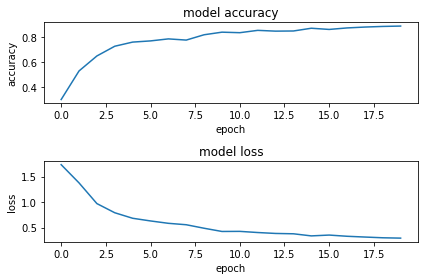

In [22]:
#Plot history and accuracy
plt.subplot(211)
plt.plot(history.history['sparse_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')

plt.subplot(212)
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.tight_layout()
plt.show() 